# Multiscale time series forecasting

The goal of this notebook is to demonstrate the framework of simultaneous forecasting of multiple multiscale time series. The forecasting procedure includes the following steps:
* time scaling 
* reduction of forecasting to regression
* feature generation
* feature selection
* regression

In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys

os.chdir(os.path.abspath(os.path.join('..'))) # !! current dir is changed here, so don't run this sell more then once!
if not "LoadAndSaveData" in os.listdir(os.curdir) or "RegressionMatrix" not in os.listdir(os.curdir) \
                                                        or "Forecasting" not in os.listdir(os.curdir):
    print("Restart the kernel!")

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from RegressionMatrix import regression_matrix, random_data
from LoadAndSaveData import load_time_series
from Forecasting import frc_class
import my_plots
from collections import namedtuple
tsStruct = namedtuple('tsStruct', 'data request history name readme')

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# Load your modules

## Loading data
For now, use the default dataset

In [3]:
# See if the data is downloaded yet:
# (recommended to set load_raw=True if you haven't updated the repo for a long time)
load_raw = not os.path.exists(os.path.join("ProcessedData", "EnergyWeather_orig_train.pkl"))

# The following returns a list of TsStructure-s
ts_struct = load_time_series.load_all_time_series(datasets='EnergyWeather', load_raw=load_raw, name_pattern="train")
ts_struct = ts_struct[0] # let's just pick the first one

# Display results:
print("Time series name: {}".format(ts_struct.name))
print(ts_struct.readme)
print(ts_struct.summarize_ts())

Time series name: EnergyWeather_missing_value_train_0.01
Energy-weather time series with artificially inserted missing values


LoadAndSaveData\raw_time_series.py:175: FutureWarning: using '-' to provide set differences with datetimelike Indexes is deprecated, use .difference()
  ts_delta = min(ts.index[1:] - ts.index[:-1]) - pd.to_datetime("1970-01-01")


                   N. obs.            Min            Max     T. min  \
Energy               20096  119995.000000  602703.000000 1999-01-01   
Max Temperature       1081      -9.913000      35.712002 1999-01-01   
Min Temperature       1085     -16.389000      20.694000 1999-01-01   
Precipitation         1084       0.000000      32.689484 1999-01-01   
Wind                  1086       0.869133       8.273607 1999-01-01   
Relative Humidity     1083       0.295366       0.997529 1999-01-01   
Solar                 1080       0.293850      30.174639 1999-01-01   

                                T.max            T. delta     Nans %  
Energy            2001-12-31 23:00:00 11687 days 23:00:00  23.600973  
Max Temperature   2001-12-31 00:00:00 11687 days 00:00:00   1.368613  
Min Temperature   2001-12-31 00:00:00 11687 days 00:00:00   1.003650  
Precipitation     2001-12-31 00:00:00 11687 days 00:00:00   1.094891  
Wind              2001-12-31 00:00:00 11687 days 00:00:00   0.912409  
Relat

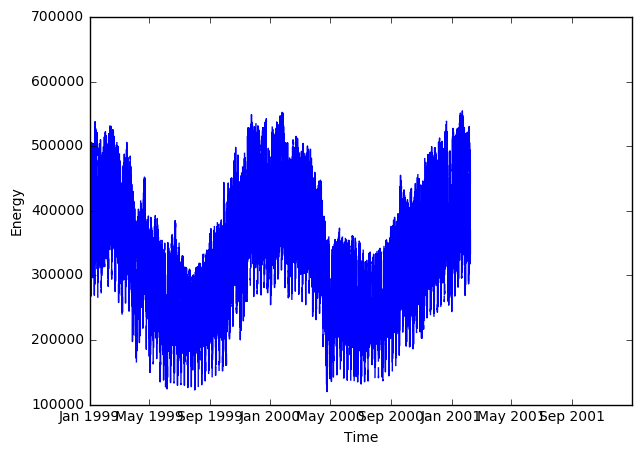

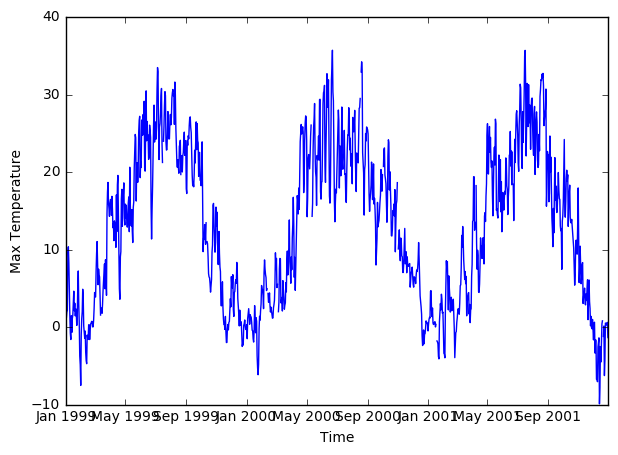

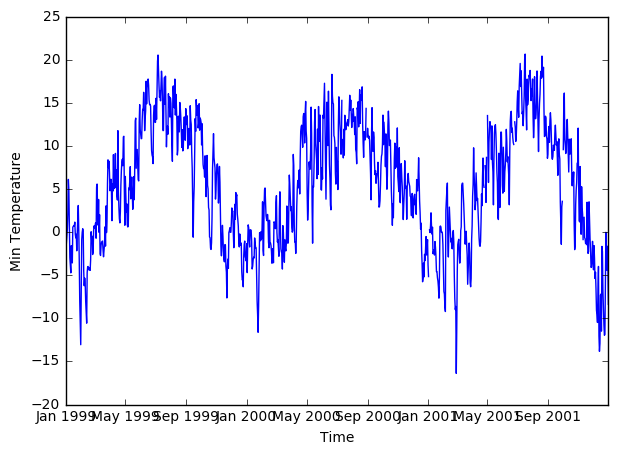

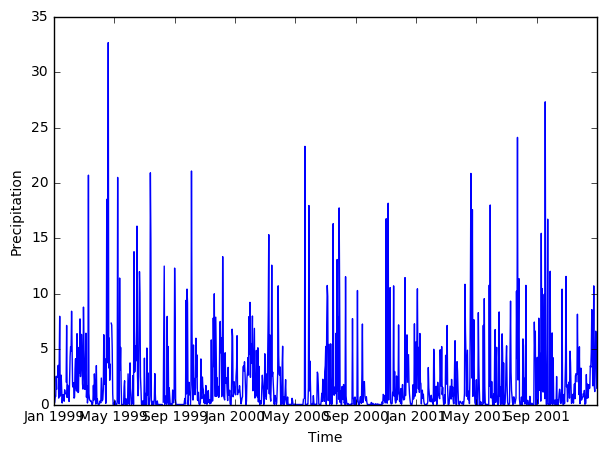

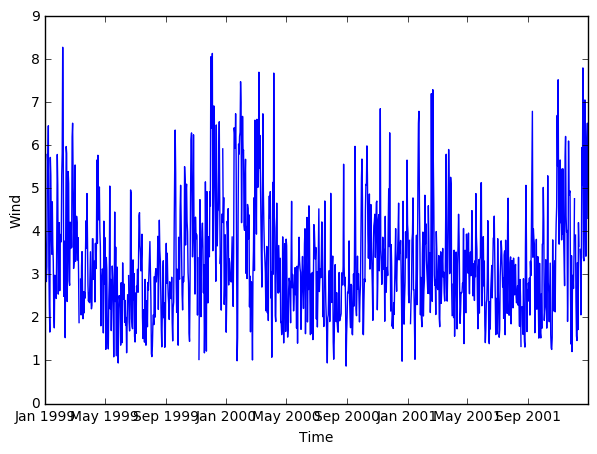

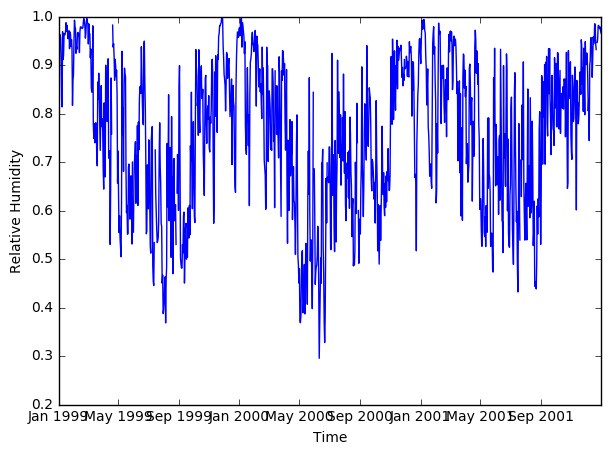

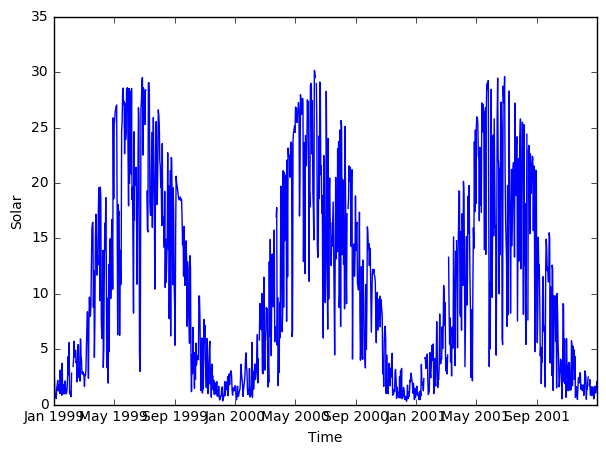

In [4]:
# plot the data
# display.clear_output(wait=True)
for ts in ts_struct.data:
    plt.figure(figsize=(7, 5))
    #plt.title("Time series" + ts_struct.name)
    plt.xlabel("Time")
    plt.ylabel(ts.name)
    plt.plot(ts.T, 'b')
    plt.show()

## Problem statement

Consider a large set of time series $\{\mathbf{s}^{(q)}| \; q = 1,\dots, {Q}\}$, where each real-valued time series $\mathbf s$
$$ \mathbf{s} = [s_1, \dots, s_i, \dots, s_{T}], ~ s_i = s(t_i),\quad 0 \leq t_i \leq t_{\max} $$
is a sequence of observations $s_i = s(t_i)$ of some real-valued signal $s(t)$.

The task is to obtain forecasts $\hat{s}(t_i)$ for  $\Delta t_r <  t_i \leq T_{\max} + \Delta t_r$, given the set $\{\mathbf{s}^{(q)}| \; q = 1,\dots, {Q}\}$

### Time scaling

Each time series $\mathbf{s}^{(q)}$ has its own sampling rate $1/\tau^{(q)}$: $t_i^{(q)} = {i}\cdot\tau^{(q)}.$ Time entries may be uneven. The task is to approximate/resample time series, so that the time entries are evenly placed.

In [5]:
# (Is yet to come)
# For now the time scaling problem is not an issue
# Missing values are imputed inside create_matrix() method.

### Forecasting as regression problem

The design matrix $\mathbf{X}^*$ for the multiscale autoregressive problem statement is constructed  as follows. Let $\mathbf{s}^{(q)}_i$ denote the~$i$-th segment of the time series $\mathbf{s}^{(q)}$
$$
[\mathbf{x}^{(q)}_i | \mathbf{y}^{(q)}_i] =
 \underbrace{s^{(q)}(t_i-\Delta t_r-\Delta t_p),\dots,}_{\mathbf{x}^{(q)}_i} \underbrace{s^{(q)}(t_i-\Delta t_r),\;\dots,s^{(q)}(t_i))}_{\mathbf{y}^{(q)}_i}], $$

where $s^{(q)}(t)$ is an element of time series $\mathbf{s}^{(q)}$.

To construct the design matrix, select $t_i$, $i = 1, \dots, m$ from $\{t_1, \dots, t_T\}$ such that segments $\mathbf{s}_i = [\mathbf{x}_i|\mathbf{y}_i]$ cover time series $\mathbf{s}$ without intersection in target parts  $\mathbf{y}_i$:
$$ |t_{i+1} - t_i| > \Delta t_r. $$
Extract segments $[\mathbf{x}^{(q)}_i | \mathbf{y}^{(q)}_i]$, $i = 1, \dots, m$ from all time series $\mathbf{s}^{(q)}$ and form the matrix $\mathbf{X}^*$.

In [6]:
# Create regression matrix X*
TS_IDX = [0, 1, 2, 4, 5, 6] # exclude Precipitation from the list

# create RegMatrix object:
data = regression_matrix.RegMatrix(ts_struct, x_idx=TS_IDX, y_idx=TS_IDX) # if x_idx and y_idx are not specified, all ts will be used
data.create_matrix(nsteps=1, norm_flag=True) # make data.X and data.Y from ts

print("Data shape: X {}, Y {}".format(data.X.shape, data.Y.shape))

Data shape: X (1089L, 203L), Y (1089L, 29L)


### Feature generation and selection
Coming soon...

In [7]:
# Dummy models:
# leave these as they are if you don't want any feature generation / selection 
generator = frc_class.IdentityGenerator(name="Identity generator")
selector = frc_class.IdentityModel(name="Identity selector")

# or add some transformations:
def transform(X):
    return np.hstack((X, np.power(X, 2)))
generator.transform = transform

### Example forecast

In [8]:
# split into train and test
TRAIN_TEST_RATIO = 0.75
data.train_test_split(TRAIN_TEST_RATIO)

# Define a forecasting model. Substitute Lasso in this example with your model class. 
frc_model = frc_class.CustomModel(Lasso, name="Lasso", alpha=0.01) # Your model here! The model should have .fit(X, y) and .predict(X) methods

# The trained model incorporates feature generation and selection schemes:
# here model is pipeline with steps frc, gen, sel
model, frc, sel, gen = data.train_model(frc_model=frc_model, generator=generator, selector=selector)


In [9]:
# Regress X on Y and ravel Y to data.forecasts (list of data.nts 1d-arrays)
# Also returns unraveled (matrix) forecasts frc_mat:
frc_mat, _ = data.forecast(model, replace=True) # replace=True: new forecasts overwrite data.forecasts; first "history" inputs are left zero

# Errors:
train_mae = data.mae(idx_rows=data.idx_train, out=None)
train_mape = data.mape(idx_rows=data.idx_train, out=None)

test_mae = data.mae(idx_rows=data.idx_test, out=None)
test_mape = data.mape(idx_rows=data.idx_test, out=None)

In [10]:
# Make a table with errors:
index = [ts_struct.data[i].name for i in TS_IDX]
res1 = pd.DataFrame(train_mae, index=index, columns=[("MAE", "train")])
res2 = pd.DataFrame(train_mape, index=index, columns=[("MAPE", "train")])
res3 = pd.DataFrame(test_mae, index=index, columns=[("MAE", "test")])
res4 = pd.DataFrame(test_mape, index=index, columns=[("MAPE", "test")])
res = pd.concat([res1, res2, res3, res4], axis=1)
print(res)

# optionally, save results to latex file (this will create file out_fname.tex in python_code/)
my_plots.save_to_latex([res], df_names="Time series {0} forecasted with {1} + '{2}' feature generation model and '{3}' feature selection model \n \\\\".
                       format(ts.name, frc.name, gen.name, sel.name), file_name="out_fname")

                   (MAE, train)  (MAPE, train)   (MAE, test)  (MAPE, test)
Energy             30801.025391       0.104901  34794.183594      0.122615
Max Temperature        2.860452       2.353532      3.230273      0.974536
Min Temperature        2.355285       5.069021      2.891017      1.170652
Wind                   0.892750       0.326741      0.837202      0.324539
Relative Humidity      0.072814       0.108787      0.077422      0.108106
Solar                  3.321194       0.830028      4.298123      0.848472


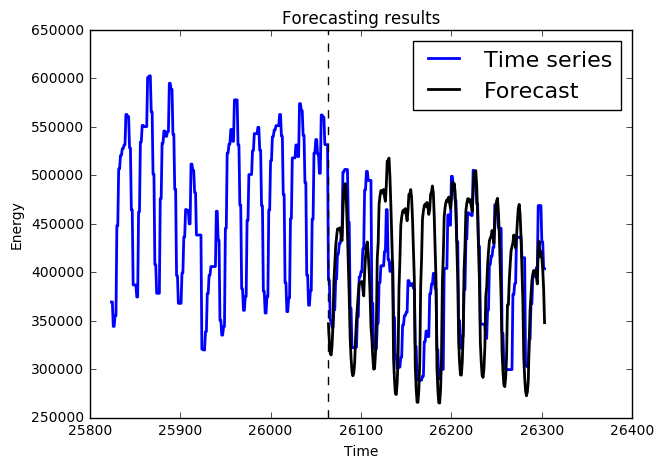

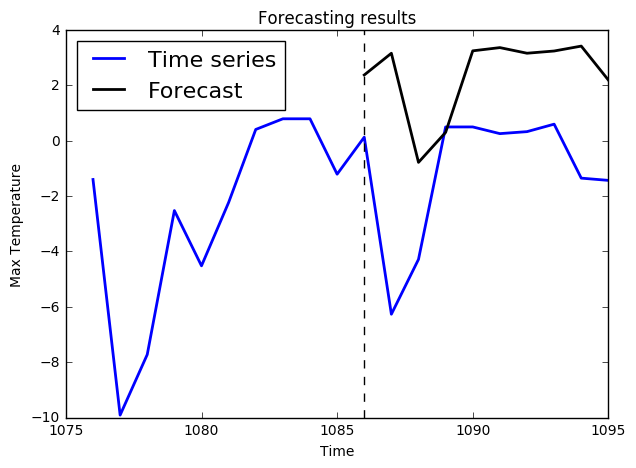

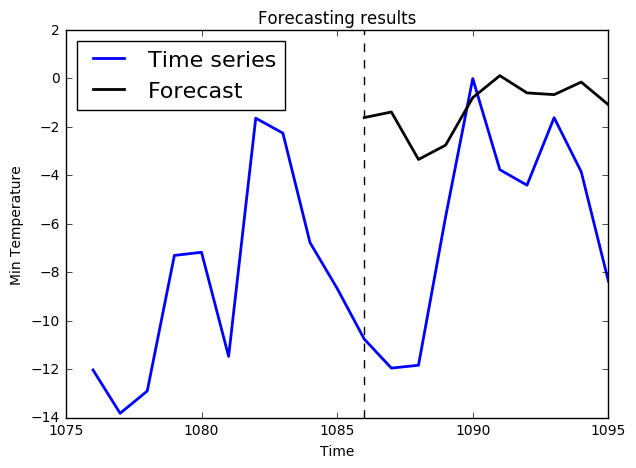

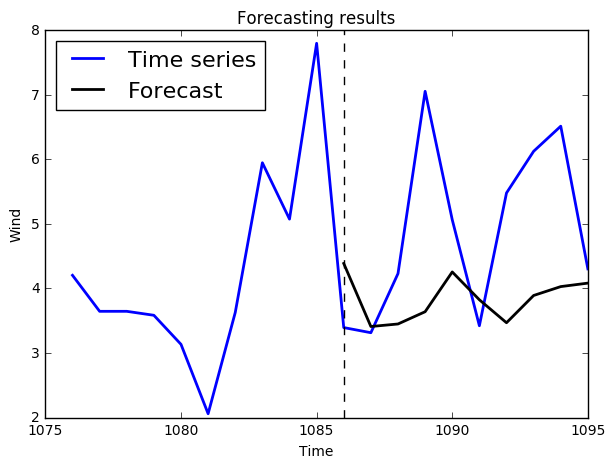

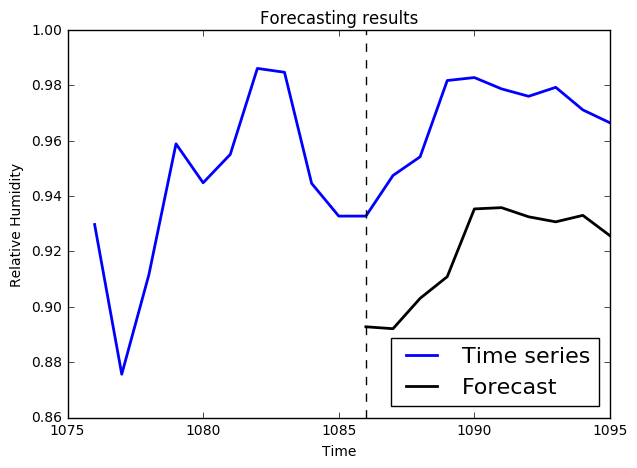

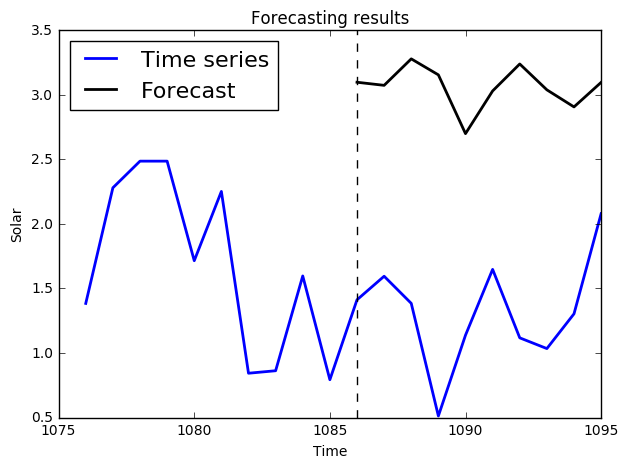

In [11]:
# plot results
data.plot_frc(n_frc=10, n_hist=10, save=False)